In [1]:
from numpy import loadtxt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Embedding, Concatenate
from keras.models import Sequential, Model
from keras.layers import Lambda
from keras.layers.core import Permute
from keras import backend as K
from keras.engine.topology import Layer
import keras
import sklearn as sk
from sklearn.linear_model import LassoLarsCV
from sklearn.decomposition import PCA
import sklearn.tree 
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from numpy.random import rand
from pylab import figure
from scipy.stats import mstats
from scipy.stats import spearmanr, kendalltau
from sklearn.model_selection import train_test_split
import sklearn.ensemble
import pandas as pd
import abc
from scipy.optimize import minimize
from scipy.spatial import distance
from scipy import linalg


In [2]:
# seqs
X_raw_seqs = loadtxt('../march5_labels_and_seq.csv',delimiter=',',dtype="str",usecols=0)

# labels/values
y_raw_values = mstats.winsorize(loadtxt('../march5_labels_and_seq.csv',delimiter=',',usecols=1),limits=[0.01, 0.01]) #clip at 1% to round # 1 are the continuous
y_raw_classes = loadtxt('../march5_labels_and_seq.csv',delimiter=',',usecols=2) # 2 are hard 0 or 1

In [3]:
# doc2vec embeddings
X_raw_doc2vec_original_3_7 = loadtxt("../march5_embeds_normal_3_7.csv",delimiter=",")
X_raw_doc2vec_original_5_7 = loadtxt("../march5_embeds_normal_5_7.csv",delimiter=",")
X_raw_doc2vec_random_3_7 = loadtxt("../march5_embeds_random_3_7.csv",delimiter=",")
X_raw_doc2vec_scrambled_3_5 = loadtxt("../march5_embeds_scrambled_3_5.csv",delimiter=",")
X_raw_doc2vec_uniform_4_1 = loadtxt("../march5_embeds_uniform_4_1.csv",delimiter=",")

# evcouplings
X_raw_ev_independent = loadtxt('../march5_labels_and_seq_with_evcouplings.csv',delimiter=',',usecols=3) # 3 is indep
X_raw_ev_epistasis = loadtxt('../march5_labels_and_seq_with_evcouplings.csv',delimiter=',',usecols=4) #4 is epistasis, #2 is rounded, #1 is continuous, #0 is seq

# VAE
X_raw_vae_scores = loadtxt('../march5_deepsequence_scores.tab',delimiter='\t',usecols=3)
X_raw_vae_latent = loadtxt('../march5_deepsequence_latent.tab',delimiter='\t',usecols=np.arange(3,33))
X_raw_vae_mu = loadtxt('../march5_deepsequence_mu.tab',delimiter='\t',usecols=np.arange(3,33))
X_raw_vae_sigma = loadtxt('../march5_deepsequence_sigma.tab',delimiter='\t',usecols=np.arange(3,33))

# rosetta
X_raw_free_avgddg = loadtxt('../march5_rosetta_values.tab',delimiter='\t',usecols=3) #3 is free avgddg,4 free avgtotal
X_raw_free_avgtotal = loadtxt('../march5_rosetta_values.tab',delimiter='\t',usecols=4)
X_raw_dna_avgddg = loadtxt('../march5_rosetta_values.tab',delimiter='\t',usecols=5) # 5 is dna avgddg,6 dna avgtotal
X_raw_dna_avgtotal = loadtxt('../march5_rosetta_values.tab',delimiter='\t',usecols=6)
X_raw_tetramer_avgddg = loadtxt('../march5_rosetta_tetramer_values.tab',delimiter='\t',usecols=3) #3 is free avgddg,4 free avgtotal
X_raw_tetramer_avgtotal = loadtxt('../march5_rosetta_tetramer_values.tab',delimiter='\t',usecols=4)

In [4]:
# unirep
X_raw_reps = loadtxt('../march5_reps.csv',delimiter=',')
#X_raw_tape_reps = loadtxt('../_unirep_from_TAPE/reps_43669_avg_march5.csv',delimiter=',')

In [5]:
# load bert
X_raw_bert = loadtxt('../_bert/bert_43669_march5_768.csv',delimiter=',')
#X_raw_bert_pooled = loadtxt('../_bert/bert_43669_pooled_march5_768.csv',delimiter=',')

In [6]:
singles_idx = loadtxt('_subset_analysis/march5_singles_regular.csv',delimiter=',',usecols=9,dtype=int)
doubles_idx = loadtxt('_subset_analysis/march5_doubles_regular.csv',delimiter=',',usecols=9,dtype=int)
triples_idx = loadtxt('_subset_analysis/march5_triples_or_more_regular.csv',delimiter=',',usecols=9,dtype=int)
singles_100_idx = loadtxt('_subset_analysis/march5_singles_gte100.csv',delimiter=',',usecols=9,dtype=int)
doubles_100_idx = loadtxt('_subset_analysis/march5_doubles_gte100.csv',delimiter=',',usecols=9,dtype=int)
triples_100_idx = loadtxt('_subset_analysis/march5_triples_or_more_gte100.csv',delimiter=',',usecols=9,dtype=int)

train_val_idx = singles_idx
test_idx = doubles_idx

print(X_raw_reps[singles_idx,0])

[0.01323    0.0139593  0.01445513 ... 0.01358554 0.01473539 0.01394954]


In [7]:
X_seqs = X_raw_seqs[train_val_idx].copy()

y_values = y_raw_values[train_val_idx].copy()
y_classes = y_raw_classes[train_val_idx].copy()

X_doc2vec_original_3_7 = X_raw_doc2vec_original_3_7[train_val_idx,:].copy()
X_doc2vec_original_5_7 = X_raw_doc2vec_original_5_7[train_val_idx,:].copy()
X_doc2vec_random_3_7 = X_raw_doc2vec_random_3_7[train_val_idx,:].copy()
X_doc2vec_scrambled_3_5 = X_raw_doc2vec_scrambled_3_5[train_val_idx,:].copy()
X_doc2vec_uniform_4_1 = X_raw_doc2vec_uniform_4_1[train_val_idx,:].copy()
X_ev_independent = X_raw_ev_independent[train_val_idx].copy()
X_ev_epistasis = X_raw_ev_epistasis[train_val_idx].copy()

X_vae_scores = X_raw_vae_scores[train_val_idx].copy()
X_vae_latent = X_raw_vae_latent[train_val_idx,:].copy()
X_vae_mu = X_raw_vae_mu[train_val_idx,:].copy()
X_vae_sigma = X_raw_vae_sigma[train_val_idx,:].copy()

X_free_avgddg = X_raw_free_avgddg[train_val_idx].copy()
X_free_avgtotal = X_raw_free_avgtotal[train_val_idx].copy()
X_dna_avgddg = X_raw_dna_avgddg[train_val_idx].copy()
X_dna_avgtotal = X_raw_dna_avgtotal[train_val_idx].copy()
X_tetramer_avgddg = X_raw_tetramer_avgddg[train_val_idx].copy()
X_tetramer_avgtotal = X_raw_tetramer_avgtotal[train_val_idx].copy()

X_reps = X_raw_reps[train_val_idx,:].copy()
#X_tape_reps = X_raw_tape_reps[train_val_idx,:].copy()
X_bert = X_raw_bert[train_val_idx,:].copy()
#X_bert_pooled = X_raw_bert_pooled[train_val_idx,:].copy()

X_test_seqs = X_raw_seqs[test_idx].copy()
y_test_values = y_raw_values[test_idx].copy()
y_test_classes = y_raw_classes[test_idx].copy()
X_test_doc2vec_original_3_7 = X_raw_doc2vec_original_3_7[test_idx,:].copy()
X_test_doc2vec_original_5_7 = X_raw_doc2vec_original_5_7[test_idx,:].copy()
X_test_doc2vec_random_3_7 = X_raw_doc2vec_random_3_7[test_idx,:].copy()
X_test_doc2vec_scrambled_3_5 = X_raw_doc2vec_scrambled_3_5[test_idx,:].copy()
X_test_doc2vec_uniform_4_1 = X_raw_doc2vec_uniform_4_1[test_idx,:].copy()
X_test_ev_independent = X_raw_ev_independent[test_idx].copy()
X_test_ev_epistasis = X_raw_ev_epistasis[test_idx].copy()
X_test_vae_scores = X_raw_vae_scores[test_idx].copy()
X_test_vae_latent = X_raw_vae_latent[test_idx,:].copy()
X_test_vae_mu = X_raw_vae_mu[test_idx,:].copy()
X_test_vae_sigma = X_raw_vae_sigma[test_idx,:].copy()
X_test_free_avgddg = X_raw_free_avgddg[test_idx].copy()
X_test_free_avgtotal = X_raw_free_avgtotal[test_idx].copy()
X_test_dna_avgddg = X_raw_dna_avgddg[test_idx].copy()
X_test_dna_avgtotal = X_raw_dna_avgtotal[test_idx].copy()
X_test_tetramer_avgddg = X_raw_tetramer_avgddg[test_idx].copy()
X_test_tetramer_avgtotal = X_raw_tetramer_avgtotal[test_idx].copy()
X_test_reps = X_raw_reps[test_idx,:].copy()
#X_test_tape_reps = X_raw_tape_reps[test_idx,:].copy()
X_test_bert = X_raw_bert[test_idx,:].copy()
#X_test_bert_pooled = X_raw_bert_pooled[test_idx,:].copy()

In [8]:
print(X_seqs.shape)
print(y_values.shape)
print(y_classes.shape)
print(X_doc2vec_original_3_7.shape)
print(X_doc2vec_original_5_7.shape)
print(X_doc2vec_random_3_7.shape)
print(X_doc2vec_scrambled_3_5.shape)
print(X_doc2vec_uniform_4_1.shape)
print(X_ev_independent.shape)
print(X_ev_epistasis.shape)
print(X_vae_scores.shape)
print(X_vae_latent.shape)
print(X_vae_mu.shape)
print(X_vae_sigma.shape)
print(X_free_avgddg.shape)
print(X_free_avgtotal.shape)
print(X_dna_avgddg.shape)
print(X_dna_avgtotal.shape)
print(X_tetramer_avgddg.shape)
print(X_tetramer_avgtotal.shape)
print(X_reps.shape)
print(X_bert.shape)

(5009,)
(5009,)
(5009,)
(5009, 64)
(5009, 64)
(5009, 64)
(5009, 64)
(5009, 64)
(5009,)
(5009,)
(5009,)
(5009, 30)
(5009, 30)
(5009, 30)
(5009,)
(5009,)
(5009,)
(5009,)
(5009,)
(5009,)
(5009, 1900)
(5009, 768)


In [9]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

X_intencode = np.zeros((X_seqs.shape[0],360))
X_onehot = np.zeros((X_seqs.shape[0],360*20))
X_onehot2d = np.zeros((X_seqs.shape[0],360,20))

for i,seq in enumerate(X_seqs):
    X_intencode[i,:] = LabelEncoder().fit_transform(np.array(list(seq)))
    X_onehot[i,:] = OneHotEncoder(sparse=False, categories='auto').fit_transform(
                    LabelEncoder().fit_transform(
                    np.array(list(seq))).reshape(360,1)).reshape(-1)
    X_onehot2d[i,0:360,0:20] = OneHotEncoder(sparse=False, categories='auto').fit_transform(
                    LabelEncoder().fit_transform(
                    np.array(list(seq))).reshape(360,1))

In [10]:
print(X_intencode[0,:])

[ 0.  8. 12. 17. 16.  9. 19.  2. 17.  0.  3. 19.  0.  5. 17. 15. 19. 13.
 16. 17. 15. 14. 17. 17. 11. 13.  0. 15.  6. 17. 15.  0.  8. 16. 14.  3.
  8. 17.  3.  0.  0. 10.  0.  3.  9. 11. 19.  7. 12. 11. 14. 17.  0. 13.
 13.  9.  0.  5.  8. 13. 15.  9.  9.  7.  5. 17.  0. 16. 15. 15.  9.  0.
  9.  6.  0. 12. 15. 13.  7. 17.  0.  0.  7.  8. 15. 14.  0.  2. 13.  9.
  5.  0. 15. 17. 17. 17. 15. 10. 17.  3. 14. 15.  5. 17.  3.  0.  1.  8.
  0.  0. 17.  6. 11.  9.  9.  0. 13. 14. 17. 15.  5.  9.  7.  7. 11. 19.
 12.  9.  2.  2. 13.  2.  0.  7.  0. 17.  3.  0.  0.  1. 16. 11. 17. 12.
  0.  9.  4.  9.  2. 17. 15.  2. 13. 16. 12.  7. 11. 15.  7.  7.  4. 15.
  6.  3.  2.  5. 16. 14.  9.  5. 17.  3.  6.  9. 17.  0.  9.  5.  6. 13.
 13.  7.  0.  9.  9.  0.  5. 12.  9. 15. 15. 17. 15.  0. 14.  9. 14.  9.
  0.  5. 18.  6.  8. 19.  9. 16. 14. 11. 13.  7. 13. 12.  7.  0.  3. 14.
  3.  5.  2. 18. 15.  0. 10. 15.  5.  4. 13. 13. 16. 10. 13. 10.  9. 11.
  3.  5.  7. 17. 12. 16.  0. 10.  9. 17.  0. 11.  2

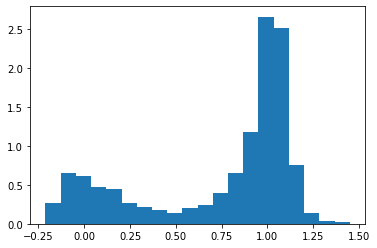

In [11]:
plt.hist(y_values, density=True, bins=20)
plt.show()

In [12]:
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras import backend as K

def tf_pearson(x, y):
    x = tf.keras.backend.cast(x, dtype='float64') 
    y = tf.keras.backend.cast(y, dtype='float64') 
    
    mx = tf.math.reduce_mean(x)
    my = tf.math.reduce_mean(y)
    xm, ym = x-mx, y-my
    r_num = tf.math.reduce_mean(tf.multiply(xm,ym))        
    r_den = tf.math.reduce_std(xm) * tf.math.reduce_std(ym)
    return r_num / r_den

def tf_pearson_loss(x, y):
    #x = tf.keras.backend.cast(x, dtype='float64') 
    #y = tf.keras.backend.cast(y, dtype='float64') 
    
    mx = tf.math.reduce_mean(x)
    my = tf.math.reduce_mean(y)
    xm, ym = x-mx, y-my
    r_num = tf.math.reduce_mean(tf.multiply(xm,ym))        
    r_den = tf.math.reduce_std(xm) * tf.math.reduce_std(ym)
    return 1 - r_num / r_den

def pearson_r(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den

    #r = K.maximum(K.minimum(r, 1.0), -1.0)
    #return 1 - K.square(r)
    return r

def rounded_accuracy(y_true, y_pred):
    x = tf.keras.backend.cast(y_true, dtype='float64') 
    y = tf.keras.backend.cast(y_pred, dtype='float64') 
    x = K.clip(x, 0, 1)
    y = K.clip(y, 0, 1)
    return K.mean(K.equal(K.round(x), K.round(y)))

def recall(y_true, y_pred):
    y_true = tf.keras.backend.cast(y_true, dtype='float64') 
    y_pred = tf.keras.backend.cast(y_pred, dtype='float64')  
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = tf.keras.backend.cast(y_true, dtype='float64') 
    y_pred = tf.keras.backend.cast(y_pred, dtype='float64') 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((prec*rec)/(prec+rec+K.epsilon()))

def quick_scatter(name,x,y):
    plt.figure(figsize=(6,6))
    plt.ylim(-0.5,1.5)
    plt.xlim(-0.5,1.5)
    sn.scatterplot(x,y).set_title(name)
    plt.show()

def quick_hexbin(name,x,y):
    plt.figure(figsize=(6,6))
    sn.jointplot(x,y, kind="hex",ylim=[-0.5,1.5],xlim=[-0.5,1.5],bins="log",gridsize=10000)
    plt.show()

def quick_scatter3d(m3d=np.ones((1,1,1))):
    
    m = m3d # m is an array of (x,y,z) coordinate triplets
    fig = figure()
    ax = Axes3D(fig)
    for i in np.arange(20): #plot each point + it's index as text above
        ax.scatter(m[i,0],m[i,1],m[i,2],color='b') 
        ax.text(m[i,0],m[i,1],m[i,2],  '%s' % (labels[i]), size=20, zorder=1,  
        color='k') 
    pyplot.show()

def print_metrics(name,ytrue,yhat):
    mse = sk.metrics.mean_squared_error(ytrue,yhat)
    cor = tf_pearson(ytrue,yhat)
    spear,spear_p = spearmanr(ytrue,yhat)
    acc = rounded_accuracy(ytrue,yhat)
    prec = precision(ytrue,yhat)
    rec = recall(ytrue,yhat)
    f1 = f1_score(ytrue,yhat)
    
    tf.print(name,end="\t")
    tf.print(mse,end="\t")
    tf.print(cor,end="\t")
    tf.print(spear,end="\t")
    tf.print(acc,end="\t")
    tf.print(prec,end="\t")
    tf.print(rec,end="\t")
    tf.print(f1,end="\n")

In [13]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0,patience=50, restore_best_weights=True)


In [14]:
class DynamicGraphLayer(Layer):    
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(DynamicGraphLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        init_matrix = keras.initializers.RandomUniform(minval=-1, maxval=1, seed=None)
        #init_matrix = keras.initializers.Zeros()
        #if input_shape[2] == self.output_dim:
        #    init_matrix = keras.initializers.Identity(gain=1.0)
    
        self.kernel = self.add_weight(name='kernel',
                                     shape=(input_shape[2], self.output_dim),
                                     initializer=init_matrix,
                                     trainable=True)
        super(DynamicGraphLayer, self).build(input_shape)      
    def call(self, x):
        return K.dot(x,self.kernel)    
    def compute_output_shape(self, input_shape):
        return (None,input_shape[1], self.output_dim)

# Gaussian Process Regressor    
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)



In [15]:
def linear_model(input_size=7200,act='linear'):
    model = Sequential()
    model.add(Dense(1,input_dim=input_size,activation=act,use_bias=False))
    #model.compile(loss='mse', optimizer='adam', metrics=['mse'])#,rounded_accuracy,f1])
    return model

def logistic_model(input_size=7200,act='sigmoid'):
    model = Sequential()
    model.add(Dense(1,input_dim=input_size,activation=act))
    #model.compile(loss='mse', optimizer='adam', metrics=['mse'])#,rounded_accuracy,f1])
    return model

def subnet_model(input_size=7200):
    X_in = Input(shape=(input_size,),dtype='float32')
    H = Dense(1,activation="linear")(X_in)
    H = Dense(5,activation="sigmoid")(H)
    H = Dense(1,activation="linear")(H) 
    model = Model(inputs=X_in,outputs=H)
    #model.compile(loss='mse',optimizer='adam',metrics=['mse'])
    return model

def embedding_model(dims=10):
    model = Sequential()
    model.add(Embedding(20,dims,input_length=360))
    model.add(Flatten())
    model.add(Dense(1,activation="linear"))
    #model.compile(loss='mse', optimizer='adam', metrics=['mse'])#,rounded_accuracy,f1])
    return model

def embedding_functional(dims=10):
    X_in = Input(shape=(360,20),dtype='float32')
    
    H = Lambda(lambda x: K.dot(x,A))(X_in)
    H = Flatten()(H)               
    H = Dense(1,activation="linear")(H)
    model = Model(inputs=X_in,outputs=H)
    #model.compile(loss='mse', optimizer='adam', metrics=['mse'])#,rounded_accuracy,f1])
    return model

def dynamic_graph_conv_model(dim=10, activation='linear'):
    X_in = Input(shape=(360,20),dtype='float32')
    M = DynamicGraphLayer(dim)(X_in)
    Hc = Flatten()(M)
    H = Dense(1,activation=activation)(Hc)
    model = Model(inputs=[X_in], outputs=H)
    model.compile(loss='mse',optimizer='adam',metrics=['mse'])#,correlation_coefficient_loss])#,spearman])
    return model

def mlp_model(input_size=7200):
    X_in = Input(shape=(input_size,),dtype='float32')
    #H = Dense(input_size,activation="linear")(X_in)
    #H = Dense(30,activation="sigmoid")(H) 
    H = Dense(5,activation="sigmoid")(X_in) 
    H = Dense(1,activation="sigmoid")(H) 
    model = Model(input=X_in,outputs=H)
    #model.compile(loss='mse',optimizer='adam',metrics=['mse'])
    return model

def generic_mlp_classifier(input_size=7200):
    X_in = Input(shape=(input_size,),dtype='float32')
    H = Dense(90,activation="sigmoid")(X_in) 
    H = Dense(30,activation="sigmoid")(H) 
    H = Dense(1,activation="sigmoid")(H) 
    model = Model(input=X_in,outputs=H)
    #model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

def mega_model(input1_size=1900,input2_size=768):
    initializer = tf.keras.initializers.Identity()
    input1 = Input(shape=(input1_size,))
    input2 = Input(shape=(input2_size,))
    densea = Dense(1,activation='linear')(input1)
    #densea = Dropout(0.2)(densea)
    denseb = Dense(1,activation='linear')(input2)
    #denseb = Dropout(0.2)(denseb)
    merged = Concatenate(axis=1)([densea, denseb])
    merged = Dense(1)(merged)
    #dense1 = Dense(10,activation="sigmoid")(merged)
    output = Dense(1)(merged)
    model = Model(inputs=[input1, input2], output=output)
    model.compile(loss='mse',optimizer='adam',metrics=['mse'])
    return model

def mege_pretrained(input1_size=1900,input2_size=768):
    input1 = Input(shape=(input1_size,))
    input2 = Input(shape=(input2_size,))
    densea = Dense(1)(input1)
    denseb = Dense(1)(input2)
    merged = Concatenate(axis=1)([densea, denseb])
    #dense1 = Dense(1, input_dim=1, use_bias=True,activation="sigmoid")(merged)
    output = Dense(1)(dense1)
    model10 = Model(inputs=[input1, input2], output=output)
    return model10
  #  numpy.vstack((a,b)).T

In [16]:
data = pd.DataFrame({'binary':y_classes})
data['binary'].value_counts()[0] / data['binary'].value_counts()[1] 

0.3611413043478261

In [ ]:
unirep = sk.ensemble.ExtraTreesRegressor(n_estimators=100, random_state=0).fit(X_reps[train_ix,:],y_values[train_ix])

unirep_ensemble_extratrees	0.07114690650122583	0.77265387568232879	0.6175308849442812	0.872	0.85101010079519945	0.91576086931636924	0.8821989027158


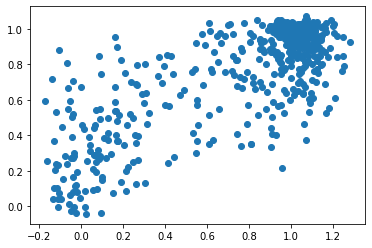

In [25]:
yhat = unirep.predict(X_reps[val_ix,:])
plt.scatter(y_values[val_ix],yhat)
print_metrics("unirep_ensemble_extratrees",y_values[val_ix],yhat)

In [63]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# now you can import normally from ensemblef
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.linear_model import RidgeCV


In [29]:
n_folds = 10
kfold = sk.model_selection.StratifiedKFold(n_folds, True, 42)

print("model\tmse\tpearson\tspearman\taccuracy\tprecision\trecall\tf1")

for train_ix, val_ix in kfold.split(X_seqs,y_classes):
    
    data = pd.DataFrame({'binary':y_classes[train_ix]})
    balanced_data = data.groupby('binary',as_index = False,group_keys=False).apply(lambda s: s.sample(50000,replace=True)).sample(frac=1,random_state=1)
    train_balanced_ix = balanced_data.index
    
    ytrue = y_values[val_ix]
    y_values_train = y_values[train_ix].copy()
    
    y_weights = y_values_train.copy()
    y_weights = np.where(y_weights > 0.5,data['binary'].value_counts()[0] / data['binary'].value_counts()[1],1)
    
    y_shuffled_train = y_values[train_ix].copy()
    np.random.shuffle(y_shuffled_train)
    

    ## Seq only
    
    onehot_lin = linear_model(input_size=7200)
    onehot_lin.compile(loss='mse',optimizer='adam',metrics=['mse'])
    onehot_lin.fit(X_onehot[train_ix,:],y_raw_values[train_ix],epochs=2000,batch_size=10,validation_split=0.1,callbacks=[es],verbose=0)      
    yhat = onehot_lin.predict(X_onehot[val_ix,:])[:,0]
    print_metrics("onehot",y_raw_values[val_ix],yhat)
    
    onehot_subnet = subnet_model(input_size=7200)
    onehot_subnet.compile(loss='mse',optimizer='adam',metrics=['mse'])
    onehot_subnet.fit(X_onehot[train_ix,:],y_raw_values[train_ix],epochs=2000,batch_size=10,validation_split=0.1,callbacks=[es],verbose=0)      
    yhat = onehot_subnet.predict(X_onehot[val_ix,:])[:,0]
    print_metrics("onehot_subnet",y_raw_values[val_ix],yhat)
    
    onehot_log = logistic_model(input_size=7200)  
    onehot_log.compile(loss='mse',optimizer='adam',metrics=['mse'])
    onehot_log.fit(X_onehot[train_ix,:],y_raw_values[train_ix],epochs=2000,batch_size=10,validation_split=0.1,callbacks=[es],verbose=0)      
    yhat = onehot_log.predict(X_onehot[val_ix,:])[:,0]
    print_metrics("onehot_logistic",y_raw_values[val_ix],yhat)

    dynconv_1 = dynamic_graph_conv_model(dim=1)
    dynconv_1.compile(loss='mse',optimizer='adam',metrics=['mse'])
    dynconv_1.fit(X_onehot2d[train_ix,:],y_raw_values[train_ix],epochs=2000,batch_size=10,validation_split=0.1,callbacks=[es],verbose=0)      
    yhat = dynconv_1.predict(X_onehot2d[val_ix,:])[:,0]
    print_metrics("dynconv-1",y_raw_values[val_ix],yhat)
    
    dynconv_5 = dynamic_graph_conv_model(dim=5)
    dynconv_5.compile(loss='mse',optimizer='adam',metrics=['mse'])
    dynconv_5.fit(X_onehot2d[train_ix,:],y_raw_values[train_ix],epochs=2000,batch_size=10,validation_split=0.1,callbacks=[es],verbose=0)      
    yhat = dynconv_5.predict(X_onehot2d[val_ix,:])[:,0]
    print_metrics("dynconv-5",y_raw_values[val_ix],yhat)
    
    dynconv_10 = dynamic_graph_conv_model(dim=10)
    dynconv_10.compile(loss='mse',optimizer='adam',metrics=['mse'])
    dynconv_10.fit(X_onehot2d[train_ix,:],y_raw_values[train_ix],epochs=2000,batch_size=10,validation_split=0.1,callbacks=[es],verbose=0)      
    yhat = dynconv_10.predict(X_onehot2d[val_ix,:])[:,0]
    print_metrics("dynconv-10",y_raw_values[val_ix],yhat)
    

model	mse	pearson	spearman	accuracy	precision	recall	f1
onehot	0.12594323107315475	0.16676672569646542	0.1788637444928549	0.846307397	0.82435129724064837	0.97405660354385448	0.89297292312637222
onehot_subnet	0.12795994458910556	0.10703180935420607	0.12067178435564975	0.846307397	0.8263473052242819	0.976415094109336	0.895135085288067
onehot_logistic	0.12774867875964221	0.11849697192587476	0.11616558675821559	0.846307397	0.82834331320791543	0.97877358467481745	0.89729724744976158
dynconv-1	0.12603930282855094	0.12688367760671845	0.09794708719631326	0.846307397	0.82235528925701484	0.971698112978373	0.89081076096467759
dynconv-5	0.13033700004704074	0.033302802110895806	0.036445062729142025	0.846307397	0.82834331320791543	0.97877358467481745	0.89729724744976158
dynconv-10	0.12124011750893386	0.24507140981185363	0.22219274049804388	0.846307397	0.82435129724064837	0.97405660354385448	0.89297292312637222
onehot	0.12473671546260821	0.27205947165378463	0.2594762149470732	0.832335353	0.8183632732

In [21]:
    ## Representation
    
    unirep = sk.linear_model.LinearRegression().fit(X_reps[train_ix,:],y_values[train_ix])
    yhat = unirep.predict(X_reps[val_ix,:])
    print_metrics("unirep_linear",ytrue,yhat)
    
    unirep = sk.linear_model.LassoLarsCV(cv=30,n_jobs=1).fit(X_reps[train_ix,:],y_values[train_ix])
    yhat = unirep.predict(X_reps[val_ix,:])
    print_metrics("unirep_lasso",ytrue,yhat)
    
    unirep = GaussianProcessRegressor(kernel= 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=2.5))
    unirep.fit(X_reps[train_ix,:],y_values[train_ix])
    yhat = unirep.predict(X_reps[val_ix,:])
    print_metrics("unirep_GPR",y_values[val_ix],yhat)
    
    unirep = sk.ensemble.ExtraTreesRegressor(n_estimators=100, random_state=0).fit(X_reps[train_ix,:],y_values[train_ix])
    yhat = unirep.predict(X_reps[val_ix,:])
    print_metrics("unirep_ensemble_extratrees",ytrue,yhat)
    
    unirep = GaussianProcessRegressor(kernel= 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=2.5))
    unirep.fit(X_reps[train_ix,:],y_shuffled_train)
    yhat = unirep.predict(X_reps[val_ix,:])
    print_metrics("unirep_Negative",y_values[val_ix],yhat)
    
    bert = sk.linear_model.LinearRegression().fit(X_bert[train_ix,:],y_values[train_ix])
    yhat = bert.predict(X_bert[val_ix,:])
    print_metrics("bert_linear",ytrue,yhat)
    
    bert_lasso = sk.linear_model.LassoLarsCV(cv=30,n_jobs=1).fit(X_bert[train_ix,:],y_values[train_ix])
    yhat = bert_lasso.predict(X_bert[val_ix,:])
    print_metrics("bert_lasso",ytrue,yhat)
    
    bert = GaussianProcessRegressor(kernel= 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=2.5))
    bert.fit(X_bert[train_ix,:],y_values[train_ix])
    yhat = bert.predict(X_bert[val_ix,:])
    print_metrics("bert_GPR",y_values[val_ix],yhat)
    
    bert = sk.ensemble.ExtraTreesRegressor(n_estimators=100, random_state=0).fit(X_bert[train_ix,:],y_values[train_ix])
    yhat = bert.predict(X_bert[val_ix,:])
    print_metrics("bert_ensemble_extratrees",ytrue,yhat)
    
    bert = GaussianProcessRegressor(kernel= 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=2.5))
    bert.fit(X_bert[train_ix,:],y_shuffled_train)
    yhat = bert.predict(X_bert[val_ix,:])
    print_metrics("bert_Negative",y_values[val_ix],yhat)
    
    vaelatent = sk.linear_model.LinearRegression().fit(X_vae_latent[train_ix,:],y_values[train_ix])
    yhat = vaelatent.predict(X_vae_latent[val_ix,:])
    print_metrics("vaelatent_linear",ytrue,yhat)
    
    vaelatent = sk.linear_model.LassoLarsCV(cv=30,n_jobs=1).fit(X_vae_latent[train_ix,:],y_values[train_ix])
    yhat = vaelatent.predict(X_vae_latent[val_ix,:])
    print_metrics("vaelatent_lasso",ytrue,yhat)
    
    vaelatent = GaussianProcessRegressor(kernel= 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=2.5))
    vaelatent.fit(X_vae_latent[train_ix,:],y_values[train_ix])
    yhat = vaelatent.predict(X_vae_latent[val_ix,:])
    print_metrics("vaelatent_GPR",y_values[val_ix],yhat)
    
    ## Doc2Vec
    
    doc2vec = GaussianProcessRegressor(kernel= 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=2.5))
    doc2vec.fit(X_doc2vec_original_3_7[train_ix,:],y_shuffled_train)
    yhat = doc2vec.predict(X_doc2vec_original_3_7[val_ix,:])
    print_metrics("Doc2Vec_Negative_GPR",y_values[val_ix],yhat)
    
    doc2vec = sk.linear_model.LinearRegression().fit(X_doc2vec_original_3_7[train_ix,:],y_shuffled_train)
    yhat = doc2vec.predict(X_doc2vec_original_3_7[val_ix,:])
    print_metrics("Doc2Vec_Negative_linear",y_values[val_ix],yhat)
    
    doc2vec = sk.linear_model.LinearRegression().fit(X_doc2vec_original_3_7[train_ix,:],y_values[train_ix])
    yhat = doc2vec.predict(X_doc2vec_original_3_7[val_ix,:])
    print_metrics("Doc2Vec_Original_3_7_linear",y_values[val_ix],yhat)
    
    doc2vec = GaussianProcessRegressor(kernel= 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=2.5))
    doc2vec.fit(X_doc2vec_original_3_7[train_ix,:],y_values[train_ix])
    yhat = doc2vec.predict(X_doc2vec_original_3_7[val_ix,:])
    print_metrics("Doc2Vec_Original_3_7_GPR",y_values[val_ix],yhat)
    
    doc2vec = sk.linear_model.LinearRegression().fit(X_doc2vec_original_5_7[train_ix,:],y_values[train_ix])
    yhat = doc2vec.predict(X_doc2vec_original_5_7[val_ix,:])
    print_metrics("Doc2Vec_Original_5_7_linear",y_values[val_ix],yhat)
    
    doc2vec = GaussianProcessRegressor(kernel= 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=2.5))
    doc2vec.fit(X_doc2vec_original_5_7[train_ix,:],y_values[train_ix])
    yhat = doc2vec.predict(X_doc2vec_original_5_7[val_ix,:])
    print_metrics("Doc2Vec_Original_5_7_GPR",y_values[val_ix],yhat)
    
    doc2vec = sk.linear_model.LinearRegression().fit(X_doc2vec_random_3_7[train_ix,:],y_values[train_ix])
    yhat = doc2vec.predict(X_doc2vec_random_3_7[val_ix,:])
    print_metrics("Doc2Vec_Random_3_7_linear",y_values[val_ix],yhat)
    
    doc2vec = GaussianProcessRegressor(kernel= 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=2.5))
    doc2vec.fit(X_doc2vec_random_3_7[train_ix,:],y_values[train_ix])
    yhat = doc2vec.predict(X_doc2vec_random_3_7[val_ix,:])
    print_metrics("Doc2Vec_Random_3_7_GPR",y_values[val_ix],yhat)
    
    doc2vec = sk.linear_model.LinearRegression().fit(X_doc2vec_scrambled_3_5[train_ix,:],y_values[train_ix])
    yhat = doc2vec.predict(X_doc2vec_scrambled_3_5[val_ix,:])
    print_metrics("Doc2Vec_Scrambled_3_5_linear",y_values[val_ix],yhat)
    
    doc2vec = GaussianProcessRegressor(kernel= 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=2.5))
    doc2vec.fit(X_doc2vec_scrambled_3_5[train_ix,:],y_values[train_ix])
    yhat = doc2vec.predict(X_doc2vec_scrambled_3_5[val_ix,:])
    print_metrics("Doc2Vec_Scrambled_3_5_GPR",y_values[val_ix],yhat)
    
    doc2vec = sk.linear_model.LinearRegression().fit(X_doc2vec_uniform_4_1[train_ix,:],y_values[train_ix])
    yhat = doc2vec.predict(X_doc2vec_uniform_4_1[val_ix,:])
    print_metrics("Doc2Vec_Uniform_4_1_linear",y_values[val_ix],yhat)
    
    doc2vec = GaussianProcessRegressor(kernel= 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=2.5))
    doc2vec.fit(X_doc2vec_uniform_4_1[train_ix,:],y_values[train_ix])
    yhat = doc2vec.predict(X_doc2vec_uniform_4_1[val_ix,:])
    print_metrics("Doc2Vec_Uniform_4_1_GPR",y_values[val_ix],yhat)
    
    ## Rosetta
    
    ros_tetramer_avgddg_linear = sk.linear_model.LinearRegression().fit(X_tetramer_avgddg[train_ix].reshape(-1, 1),y_values[train_ix],)
    yhat = ros_tetramer_avgddg_linear.predict(X_tetramer_avgddg[val_ix].reshape(-1, 1))
    print_metrics("rosetta_tetramer_avgddg_linear",ytrue,yhat)
    
    ros_tetramer_avgddg_logistic = logistic_model(input_size=1)
    ros_tetramer_avgddg_logistic.compile(loss='mse',optimizer='adam',metrics=['mse'])
    ros_tetramer_avgddg_logistic.fit(X_tetramer_avgddg[train_ix],y_values[train_ix],epochs=2000,batch_size=10,validation_split=0.05,callbacks=[es],verbose=0)      
    yhat = ros_tetramer_avgddg_logistic.predict(X_tetramer_avgddg[val_ix])[:,0]
    print_metrics("rosetta_tetramer_avgddg_logistic",ytrue,yhat)
    
    ros_tetramer_avgddg_subnet = subnet_model(input_size=1)
    ros_tetramer_avgddg_subnet.compile(loss='mse',optimizer='adam',metrics=['mse'])
    ros_tetramer_avgddg_subnet.fit(X_tetramer_avgddg[train_ix],y_values[train_ix],epochs=2000,batch_size=10,validation_split=0.05,callbacks=[es],verbose=0)      
    yhat = ros_tetramer_avgddg_subnet.predict(X_tetramer_avgddg[val_ix])[:,0]
    print_metrics("rosetta_tetramer_avgddg_subnet",ytrue,yhat)
    
    ros_free_avgddg_linear = sk.linear_model.LinearRegression().fit(X_free_avgddg[train_ix].reshape(-1, 1),y_values[train_ix],)
    yhat = ros_free_avgddg_linear.predict(X_free_avgddg[val_ix].reshape(-1, 1))
    print_metrics("rosetta_free_avgddg_linear",ytrue,yhat)
    
    ros_free_avgddg_logistic = logistic_model(input_size=1)
    ros_free_avgddg_logistic.compile(loss='mse',optimizer='adam',metrics=['mse'])
    ros_free_avgddg_logistic.fit(X_free_avgddg[train_ix],y_values[train_ix],epochs=2000,batch_size=10,validation_split=0.05,callbacks=[es],verbose=0)      
    yhat = ros_free_avgddg_logistic.predict(X_free_avgddg[val_ix])[:,0]
    print_metrics("rosetta_free_avgddg_logistic",ytrue,yhat)
    
    ros_free_avgddg_subnet = subnet_model(input_size=1)
    ros_free_avgddg_subnet.compile(loss='mse',optimizer='adam',metrics=['mse'])
    ros_free_avgddg_subnet.fit(X_free_avgddg[train_ix],y_values[train_ix],epochs=2000,batch_size=10,validation_split=0.05,callbacks=[es],verbose=0)      
    yhat = ros_free_avgddg_subnet.predict(X_free_avgddg[val_ix])[:,0]
    print_metrics("rosetta_free_avgddg_subnet",ytrue,yhat)

    ros_dna_avgddg_linear = sk.linear_model.LinearRegression().fit(X_dna_avgddg[train_ix].reshape(-1, 1),y_values[train_ix],)
    yhat = ros_dna_avgddg_linear.predict(X_dna_avgddg[val_ix].reshape(-1, 1))
    print_metrics("rosetta_dna_avgddg_linear",ytrue,yhat)
    
    ros_dna_avgddg_logistic = logistic_model(input_size=1)
    ros_dna_avgddg_logistic.compile(loss='mse',optimizer='adam',metrics=['mse'])
    ros_dna_avgddg_logistic.fit(X_dna_avgddg[train_ix],y_values[train_ix],epochs=2000,batch_size=10,validation_split=0.05,callbacks=[es],verbose=0)      
    yhat = ros_dna_avgddg_logistic.predict(X_dna_avgddg[val_ix])[:,0]
    print_metrics("rosetta_dna_avgddg_logistic",ytrue,yhat)
    
    ros_dna_avgddg_subnet = subnet_model(input_size=1)
    ros_dna_avgddg_subnet.compile(loss='mse',optimizer='adam',metrics=['mse'])
    ros_dna_avgddg_subnet.fit(X_dna_avgddg[train_ix],y_values[train_ix],epochs=2000,batch_size=10,validation_split=0.05,callbacks=[es],verbose=0)      
    yhat = ros_dna_avgddg_subnet.predict(X_dna_avgddg[val_ix])[:,0]
    print_metrics("rosetta_dna_avgddg_subnet",ytrue,yhat)
    
    ## Evo/Conservation 
    
    ev_ind = sk.linear_model.LinearRegression().fit(X_ev_independent[train_ix].reshape(-1, 1),y_values[train_ix])
    yhat = ev_ind.predict(X_ev_independent[val_ix].reshape(-1, 1))
    print_metrics("evo_independent_linear",ytrue,yhat)
    
    model_logistic = logistic_model(input_size=1,act="sigmoid")
    model_logistic.compile(loss='mse',optimizer='adam',metrics=['mse'])
    model_logistic.fit(X_ev_independent[train_ix],y_values[train_ix],epochs=2000,batch_size=10,validation_split=0.1,callbacks=[es],verbose=0)      
    yhat = model_logistic.predict(X_ev_independent[val_ix])[:,0]
    print_metrics("evo_independent_logistic",ytrue,yhat)
    
    model_subnet = subnet_model(input_size=1)
    model_subnet.compile(loss='mse',optimizer='adam',metrics=['mse'])
    model_subnet.fit(X_ev_independent[train_ix],y_values[train_ix],epochs=2000,batch_size=10,validation_split=0.1,callbacks=[es],verbose=0)      
    yhat = model_subnet.predict(X_ev_independent[val_ix])[:,0]
    print_metrics("evo_independent_subnet",ytrue,yhat)
    
    ev_epi = sk.linear_model.LinearRegression().fit(X_ev_epistasis[train_ix].reshape(-1, 1),y_values[train_ix])
    yhat = ev_epi.predict(X_ev_epistasis[val_ix].reshape(-1, 1))
    print_metrics("evo_epistasis_linear",ytrue,yhat)
    
    model_logistic = logistic_model(input_size=1,act="sigmoid")
    model_logistic.compile(loss='mse',optimizer='adam',metrics=['mse'])
    model_logistic.fit(X_ev_epistasis[train_ix],y_values[train_ix],epochs=2000,batch_size=10,validation_split=0.1,callbacks=[es],verbose=0)      
    yhat = model_logistic.predict(X_ev_epistasis[val_ix])[:,0]
    print_metrics("evo_epistasis_logistic",ytrue,yhat)
    
    model_subnet = subnet_model(input_size=1)
    model_subnet.compile(loss='mse',optimizer='adam',metrics=['mse'])
    model_subnet.fit(X_ev_epistasis[train_ix],y_values[train_ix],epochs=2000,batch_size=10,validation_split=0.1,callbacks=[es],verbose=0)      
    yhat = model_subnet.predict(X_ev_epistasis[val_ix])[:,0]
    print_metrics("evo_epistasis_subnet",ytrue,yhat)
    
    ev_vae = sk.linear_model.LinearRegression().fit(X_vae_scores[train_ix].reshape(-1, 1),y_values[train_ix])
    yhat = ev_vae.predict(X_vae_scores[val_ix].reshape(-1, 1))
    print_metrics("vaescore_linear",ytrue,yhat)
    
    model_logistic = logistic_model(input_size=1,act="sigmoid")
    model_logistic.compile(loss='mse',optimizer='adam',metrics=['mse'])
    model_logistic.fit(X_vae_scores[train_ix],y_values[train_ix],epochs=2000,batch_size=10,validation_split=0.1,callbacks=[es],verbose=0)      
    yhat = model_logistic.predict(X_vae_scores[val_ix])[:,0]
    print_metrics("vaescore_logistic",ytrue,yhat)
    
    model_subnet = subnet_model(input_size=1)
    model_subnet.compile(loss='mse',optimizer='adam',metrics=['mse'])
    model_subnet.fit(X_vae_scores[train_ix],y_values[train_ix],epochs=2000,batch_size=10,validation_split=0.1,callbacks=[es],verbose=0)      
    yhat = model_subnet.predict(X_vae_scores[val_ix])[:,0]
    print_metrics("vaescore_subnet",ytrue,yhat)
    
    
    
    
    
    

model	mse	pearson	spearman	accuracy	precision	recall	f1
dynconv-1	0.13302242114746818	0.16701512032173282	0.14983376329192205	0.842315376	0.7898989897394143	0.92216981110326179	0.85092486850281079
dynconv-5	0.12777559292334323	0.1734378380931732	0.21344291757511805	0.840319335	0.7995951415385435	0.93160377336518774	0.86056639890498243
dynconv-10	0.1314302237546954	0.0656251688940914	0.1096967621592986	0.846307397	0.80239520942067954	0.94811320732355819	0.86918913934773112
unirep_linear	0.5225371105704154	0.42417772859581759	0.5360871220974572	0.854291439	0.86792452806794484	0.8749999997622282	0.87144785233602362
unirep_lasso	0.08314546535895878	0.72650206416345764	0.5807962971768044	0.866267443	0.81927710823631872	0.92391304322719747	0.86845461151643832
unirep_GPR	0.07854708617707877	0.76892302701127813	0.6041065592760223	0.890219569	0.87335092325241392	0.89945652149471289	0.88621146249110949
unirep_ensemble_extratrees	0.06576890514159292	0.79820408350479755	0.6758239242804625	0.882235

Doc2Vec_Negative_GPR	0.24363560650339225	0.039138561033090352	0.04958668537603751	0.638722539	0.70316301686054428	0.78532608674311788	0.74197684341500014
Doc2Vec_Negative_linear	0.18831521515082095	0.05568932160717055	0.052813874129960074	0.734530926	0.70059880225536952	0.95380434756690091	0.80782503729138855
Doc2Vec_Original_3_7_linear	0.17431989448989108	0.27460607383354763	0.25955024715764335	0.736526966	0.702083333187066	0.91576086931636924	0.794811271439461
Doc2Vec_Original_3_7_GPR	0.15775363135585832	0.44967919359928138	0.3638057113755219	0.760479033	0.7764423075056629	0.87771739106583757	0.8239795418139606
Doc2Vec_Original_5_7_linear	0.17357271572401833	0.28048226759168643	0.22188880123947105	0.750499	0.69815195057532808	0.92391304322719747	0.79532158820943488
Doc2Vec_Original_5_7_GPR	0.16107031020676102	0.3869140745443907	0.32565143412776276	0.756487	0.727272727107438	0.86956521715500945	0.79207915812175578
Doc2Vec_Random_3_7_linear	0.17616551973830757	0.25446131982144721	0.224

rosetta_free_avgddg_linear	0.16876624948242414	0.27326393829505013	0.3414103451144162	0.738522947	0.70756646202299256	0.94021739104885393	0.80746786212684907
rosetta_free_avgddg_logistic	0.17143295295099556	0.28973751056639357	0.3413979791992615	0.764471054	0.74776785697594461	0.91032608670915049	0.82107838165189162
rosetta_free_avgddg_subnet	0.1617224879529537	0.34435945638441978	0.3414103451144162	0.764471054	0.73766816126958112	0.894021738887494	0.80835375861430181
rosetta_dna_avgddg_linear	0.1720806905834182	0.27555794645404	0.35497810515432554	0.740519	0.700803212710682	0.94836956495968217	0.80600456987823565
rosetta_dna_avgddg_logistic	0.17254518990355575	0.29669842940351393	0.35497810515432554	0.764471054	0.7411504423139047	0.91032608670915049	0.81707312105711172
rosetta_dna_avgddg_subnet	0.15571737345392297	0.37029314608843356	0.34924732706551503	0.768463075	0.744394618667176	0.90217391279832226	0.81572476598349819
evo_independent_linear	0.13968012536828264	0.47485839959323889	

evo_independent_subnet	0.1310889311052452	0.516363052449646	0.4151151471533292	0.800399184	0.78082191762994935	0.92934782583441633	0.84863518589856757
evo_epistasis_linear	0.12108245544925128	0.56111711308610435	0.5140040308737363	0.812375247	0.77251184815817253	0.8858695649766658	0.825316405720881
evo_epistasis_logistic	0.11657239545387105	0.58486115320083432	0.5140040308737363	0.816367269	0.79512195102557992	0.8858695649766658	0.83804622242385673
evo_epistasis_subnet	0.11757988258633573	0.58166180247610466	0.5110771370677755	0.810379267	0.77751756422072182	0.90217391279832226	0.83522007585143276
vaescore_linear	0.12030120898531683	0.56497332987612625	0.4896937698941681	0.814371228	0.79318734773888377	0.8858695649766658	0.83697042490537354
vaescore_logistic	0.1181922256099711	0.57932654759026925	0.4896937698941681	0.814371228	0.80740740720804749	0.88858695628027518	0.84605428366021
vaescore_subnet	0.11776115450663854	0.57674736553913852	0.4856922884895928	0.814371228	0.811414391858209

bert_lasso	0.10100992535075616	0.6682886021941421	0.53857843984403	0.842315376	0.79764705863584773	0.9211956519235881	0.85498103453198115
bert_GPR	0.07842939474341025	0.7645374916931782	0.6115240913779647	0.898203611	0.870801033366718	0.91576086931636924	0.89271518158326657
bert_ensemble_extratrees	0.10130174294573847	0.6898463222806428	0.5678528237763881	0.854291439	0.80093676796230984	0.92934782583441633	0.86037730854950634
bert_Negative	0.22131646203699099	0.078917778998615851	0.08276711103384007	0.672654688	0.71859296464356959	0.77717391283228965	0.74673624230992419
vaelatent_linear	0.1806396655244971	0.060568210036771458	0.05346648475792421	0.734530926	0.69660678628810235	0.94836956495968217	0.80322204534768371
vaelatent_lasso	0.180234188442611	0.059203174165472466	0.04381259454997281	0.734530926	0.70059880225536952	0.95380434756690091	0.80782503729138855
vaelatent_GPR	0.20716110804893229	-0.020967826407352022	0.002163275662841131	0.700598776	0.683760683614581	0.86956521715500945	